# Model Comparisson


### Import libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

### Visualize examples

#### Get original Image and Mask

In [2]:
# Get all files in validation folder
path_images = '/home/juandres/semillero_bcv/hubmap/data/processed/validation/images_with_gt'

# Get files
files = os.listdir(path_images)

print('Number of Val Images : ',len(files))

# Choose an image
selected_img = files[10]

# Load original image and mask
orig_image = Image.open(os.path.join(path_images,selected_img))

# Load mask 

Number of Val Images :  245


In [3]:
def get_all_images(name_image):

    '''
    With the path of the original image, get the original mask and the prediction made by each one of the models
    
    INPUT:
        * name_image : Name of the image contained under data/processed/validation
    OUTPUT:
        * Original image: Input image for prediction
        * Images : Original Mask (first position) and Predicted masks
        * Names : Name of all the models contain in an array of strings
    '''
    # Path to data folder
    base_path = '/home/juandres/semillero_bcv/hubmap/data'

    # Get models predictions
    models = os.listdir(os.path.join(base_path,'models_output'))

    # Load the original image
    orig_img = np.array(Image.open(os.path.join(base_path,'processed','validation','images_with_gt',name_image+'.tif')))

    # Variable for containing all masks
    masks = []

    # Load original mask 
    masks.append(np.array(Image.open(os.path.join(base_path,'processed','validation','masks',name_image+'.png'))))

    # Load the prediction of the rest of the models
    [masks.append(np.array(Image.open(os.path.join(base_path, 'models_output', model, name_image + '.png')))) for model in models]
    
    # Convert to np array and squeeze
    masks = np.array(masks).squeeze()
    masks = masks[:,:,:,0]

    return orig_img,masks,models

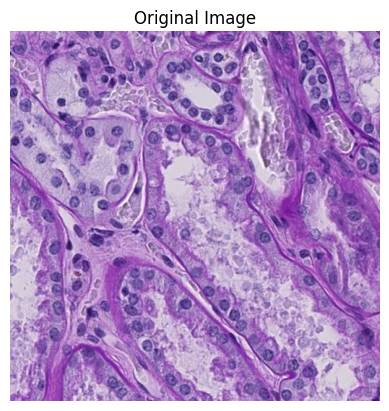

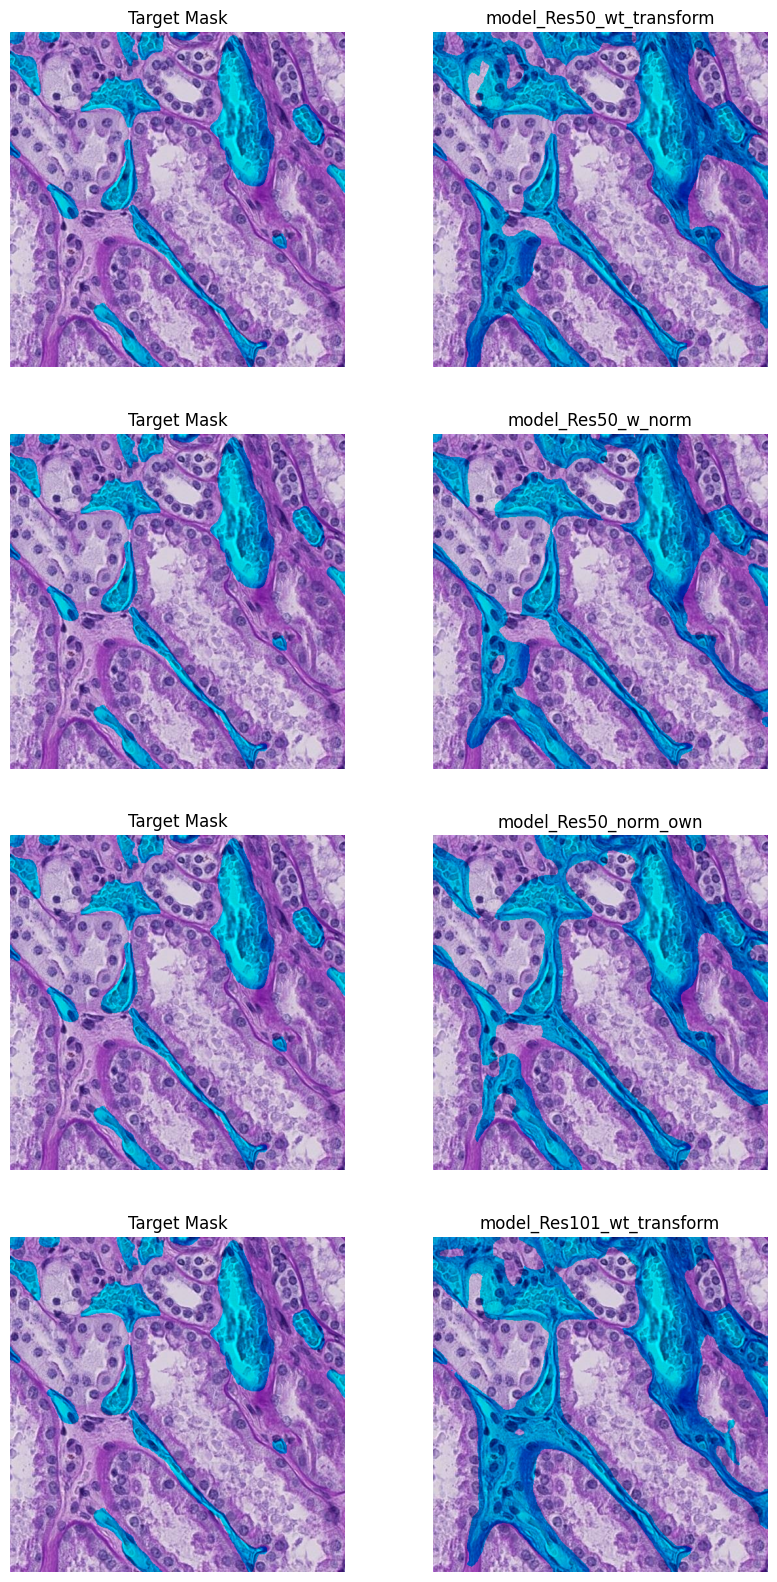

In [4]:

# List all files in validation
all_val_files = os.listdir('/home/juandres/semillero_bcv/hubmap/data/processed/validation/images_with_gt')

# Select number of file
num_file = 3

# Get predictions of a single image
input_img, masks, models = get_all_images(all_val_files[num_file].split('.tif')[0])
plt.imshow(input_img)
plt.axis('off')
plt.title('Original Image')

# Show results
fig,ax = plt.subplots(len(models),2,figsize=(10,len(models)*5))

# Original with mask
im_mask = np.copy(input_img)
im_mask[:,:,0][masks[0,:,:] == 255] = 1

for i in range(0,len(models)):
    
    # Image with predicted mask
    im_mask_pred = np.copy(input_img)
    im_mask_pred[:,:,0][masks[i+1,:,:] == 255] = 1
    
    ax[i,0].imshow(im_mask)
    ax[i,1].imshow(im_mask_pred)

    ax[i,0].set_title('Target Mask')
    ax[i,1].set_title(models[i])

    ax[i,0].axis('off')
    ax[i,1].axis('off')
